## Using Deep Learning to Predict Water Point functionality from an Image

Imports and boiler plate

In [4]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.utils import plot_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import applications, backend as K, callbacks, optimizers, regularizers

### Configuration variables for model and learning rate

In [9]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

K.set_image_dim_ordering('tf')

# dimensions of our images.
img_width, img_height = 150, 150

wp_func_model_path = 'first_try.h5'
wp_type_model_path = 'wp_type_model.h5'
fine_tuned_model_weights_path = 'finetuned_model.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'
epochs = 100
batch_size = 32
dropout = 0.5
init_lr = 1e-4

### Visualization and model training functions

In [10]:
def count_files_in_path(path):
    return sum([len(fs) for _, __, fs in os.walk(path)])
    
def plot_history(path, history):
    plt.style.use("ggplot")
    plt.figure(figsize=(12,9))
    plt.plot(np.arange(0, epochs), history["loss"], label="Train Loss")
    plt.plot(np.arange(0, epochs), history["val_loss"], label="Validation Loss")
    plt.plot(np.arange(0, epochs), history["acc"], label="Train Accuracy")
    plt.plot(np.arange(0, epochs), history["val_acc"], label="Validation Accuracy")
    plt.title("Loss and Accuracy on Water Point Classification")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="center right")
    plt.savefig(path)


def save(path, model, history):
    plot_history(path + '_performance.png', history)
    model.save(path + '_model.h5')
    model.save_weights(path + '.h5')


def create_model(optimizer='rmsprop',
                 classes=1,
                 activation='sigmoid',
                 loss='binary_crossentropy'):
    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(classes))
    model.add(Activation(activation))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model


def build_model(init_model_fn,
                class_mode,
                filename,
                train_data_dir,
                validation_data_dir,
                do_checkpoint=False,
                do_load=False):    
    if do_load:
        model = load_model(filename + '_model.h5')
    else:
        model = init_model_fn()

    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=30,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode)

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode)

    filepath = "%s.weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5" % filename
    callbacks = []
    if do_checkpoint:
        checkpoint = callbacks.ModelCheckpoint(filepath,
                                               monitor='val_acc',
                                               save_best_only=True,
                                               mode='max')
        callbacks.append(checkpoint)

    train_num_files = count_files_in_path(train_data_dir)
    validation_num_files = count_files_in_path(validation_data_dir)
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_num_files // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_num_files // batch_size,
        callbacks=callbacks)

    save(filename, model, history.history)


def get_activations(model,
                    model_inputs, 
                    print_activations=False,
                    print_shape_only=False, 
                    layer_name=None,
                    max_layer=None):
    """
    From https://github.com/philipperemy/keras-visualize-activations/blob/master/read_activations.py
    """
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    model_layers = model.layers
    
    if max_layer and not layer_name:
        model_layers = model_layers[0:max_layer]

    outputs = [layer.output for layer in model_layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    
    if print_activations:
        print('----- activations -----')

    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_activations:
            if print_shape_only:
                print(layer_activations.shape)
            else:
                print(layer_activations)

    return activations


def display_activations(activation_maps):
    """
    From https://github.com/philipperemy/keras-visualize-activations/blob/master/read_activations.py
    """
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.imshow(activations, interpolation='None', cmap='jet')
        plt.show()


def plot_trained_model(weights_path,
                       class_mode,
                       data_dir,
                       num_images,
                       classes,
                       save_model_plot):
    model = load_model(weights_path + '_model.h5')

    datagen = ImageDataGenerator(rescale=1. / 255)

    data_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        shuffle=False,
        classes=classes,
        class_mode=class_mode)

    
    for i, data in enumerate(data_generator):
        data = data[0]
        y = model.predict(data).tolist()[0][0]
        print('Classes: %s, Prediction %f' % (','.join(classes), y))

        activations = get_activations(model, data, max_layer=-1)
        display_activations(activations)

        if i > num_images:
            break

    if save_model_plot:
        plot_model(model, to_file=weights_path + '.png', show_shapes=True)

### A generic run function for common settings

In [15]:
def run(basic=False,
        init_model_fn=create_model,
        class_mode='binary',
        filename=wp_func_model_path,
        train_data_dir='data/functionality/train',
        validation_data_dir='data/functionality/validation',
        bottleneck=False,
        save_bottleneck=True,
        finetune=False, 
        analytics=False,
        num_images=1,
        classes=['nonfunc'],
        save_model_plot=False,
        predictions=False):
    ### Part I: Basic Model
    if basic:
        build_model(init_model_fn,
                    class_mode,
                    filename,
                    train_data_dir,
                    validation_data_dir)

    ### Part II: Bottleneck
    if bottleneck: 
        if save_bottleneck:
            save_bottleneck_features()
        train_top_model()

    ### Part III: Fine Tune
    if finetune:
        fine_tune()

    ### Analysis
    if analytics:
        plot_trained_model(filename,
                           class_mode,
                           validation_data_dir,
                           num_images,
                           classes,
                           save_model_plot)

    ### Prediction
    if predictions:
        predict(filename)

### Common configurations for building models

In [ ]:
adam = optimizers.Adam(lr=init_lr, decay=init_lr / epochs)

configurations = [
    ['handpump', adam]
    ['handpump', optimizers.RMSprop(lr=init_lr, decay=init_lr / epochs)],
    ['handpump', optimizers.Adagrad()],
    ['handpump', optimizers.Adadelta()],
    ['handpump', optimizers.Adam(lr=init_lr, decay=init_lr / epochs, amsgrad=True)],
    ['handpump', optimizers.Adamax()],
    ['handpump', optimizers.Nadam()],
    ['standpipe_multiple', adam],
    ['standpipe_single'adam]
]

### Build a set of models

Choose a subset of configurations to only build those particular models.

Here is a sample of outputs we received on our data:

Model | Learning Rate | Dropout | Validation Loss | Validation Accuracy
--- | --- | --- | --- | ---
ADAM | 1e-3 | 0.5 | 0.7822 | 0.7956
ADAM | 1e-4 | 0.5 | 0.5002 | 0.8052
ADAM | 1e-4 | 0.7 | 0.4982 | 0.8031
ADAM | 1e-5 | 0.5 | worse than others | worse than others
Adagrad | 1e-4 | 0.5 | 0.5158 | 0.8088
Adelta | 1e-4 | 0.5 | 0.5743 | 0.7880
ADAM AMSGrad | 1e-4 | 0.5 | ~0.5 | 0.78
Adamax | 1e-4 | 0.5 | 0.6493 | 0.8020
Nadam | 1e-4 | 0.5 | 0.6911 | 0.5367
RMSProp | 1e-4 | 0.5 | 0.5 | 0.78

In [ ]:
for folder, optimizer in configurations[0:1]:
    optimizer_name = optimizer.__class__.__name__
    filename = 'split_%s_%s_le-4_do0%s_%s_%s' % (
        folder, optimizer_name, int(dropout * 10), batch_size, epochs)
    print 'Building basic %s model for "%s" using "%s"' % (filename, folder, optimizer_name)

    run(basic=True,
        init_model_fn=lambda: create_model(
            optimizer=optimizer),
        class_mode='binary',
        filename=filename,
        train_data_dir='data/split/%s/train' % folder,
        validation_data_dir='data/split/%s/validation' % folder)

### Analyze a set of models

Choose a subset of configurations to only analyze those particular models.

Building basic split_handpump_Adam_le-4_do05_32_100 model for "handpump" using "Adam"
Found 200 images belonging to 1 classes.
Classes: nonfunc, Prediction 0.514617
Displaying activation map 0


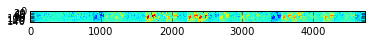

Displaying activation map 1


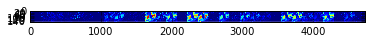

Displaying activation map 2


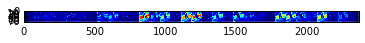

Displaying activation map 3


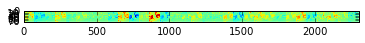

Displaying activation map 4


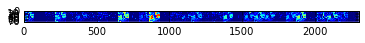

Displaying activation map 5


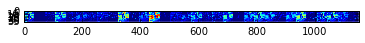

Displaying activation map 6


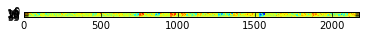

Displaying activation map 7


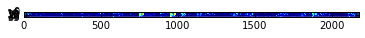

Displaying activation map 8


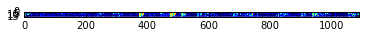

Displaying activation map 9


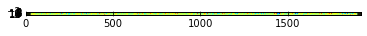

Displaying activation map 10


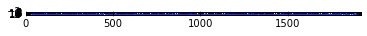

Displaying activation map 11


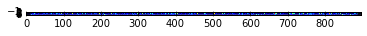

Displaying activation map 12


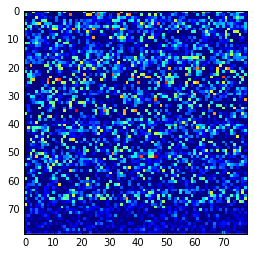

Displaying activation map 13


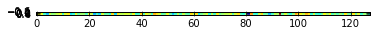

Displaying activation map 14


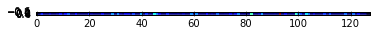

Displaying activation map 15


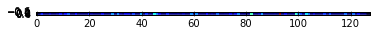

Displaying activation map 16


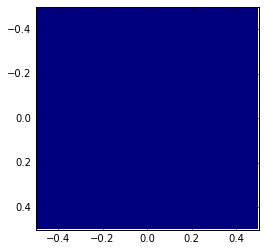

Classes: nonfunc, Prediction 0.907150
Displaying activation map 0


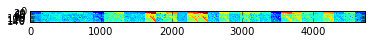

Displaying activation map 1


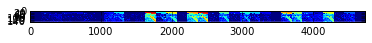

Displaying activation map 2


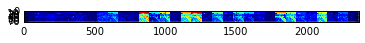

Displaying activation map 3


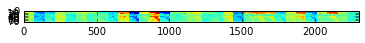

Displaying activation map 4


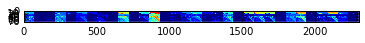

Displaying activation map 5


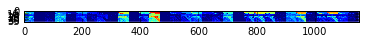

Displaying activation map 6


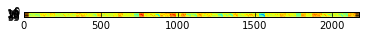

Displaying activation map 7


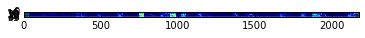

Displaying activation map 8


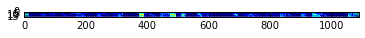

Displaying activation map 9


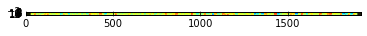

Displaying activation map 10


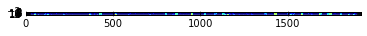

Displaying activation map 11


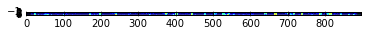

Displaying activation map 12


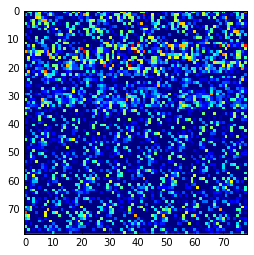

Displaying activation map 13


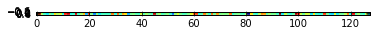

Displaying activation map 14


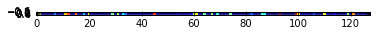

Displaying activation map 15


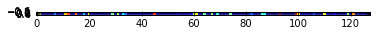

Displaying activation map 16


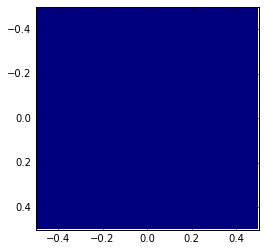

Classes: nonfunc, Prediction 0.749731
Displaying activation map 0


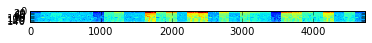

Displaying activation map 1


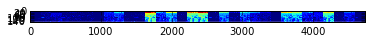

Displaying activation map 2


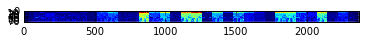

Displaying activation map 3


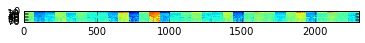

Displaying activation map 4


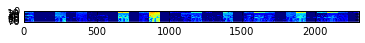

Displaying activation map 5


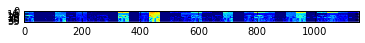

Displaying activation map 6


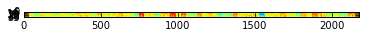

Displaying activation map 7


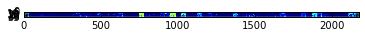

Displaying activation map 8


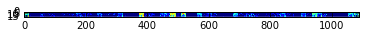

Displaying activation map 9


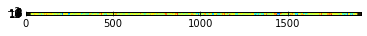

Displaying activation map 10


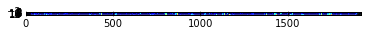

Displaying activation map 11


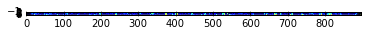

Displaying activation map 12


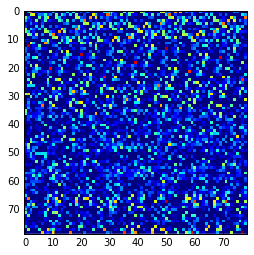

Displaying activation map 13


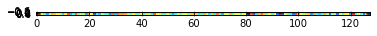

Displaying activation map 14


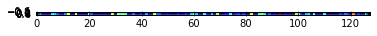

Displaying activation map 15


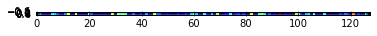

Displaying activation map 16


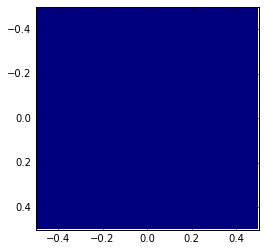

Classes: nonfunc, Prediction 0.716417
Displaying activation map 0


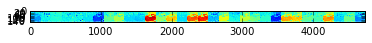

Displaying activation map 1


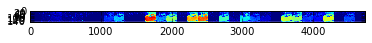

Displaying activation map 2


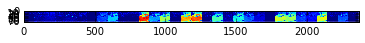

Displaying activation map 3


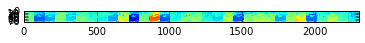

Displaying activation map 4


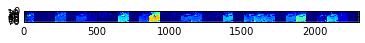

Displaying activation map 5


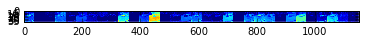

Displaying activation map 6


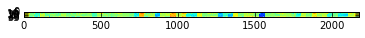

Displaying activation map 7


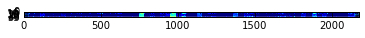

Displaying activation map 8


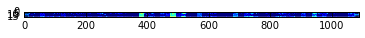

Displaying activation map 9


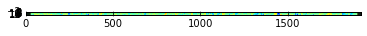

Displaying activation map 10


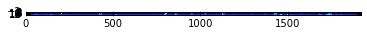

Displaying activation map 11


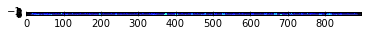

Displaying activation map 12


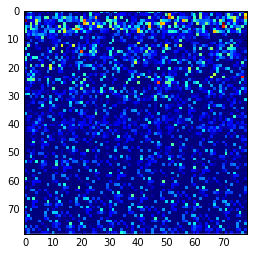

Displaying activation map 13


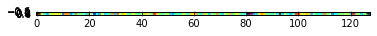

Displaying activation map 14


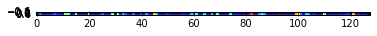

Displaying activation map 15


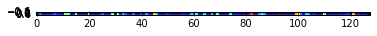

Displaying activation map 16


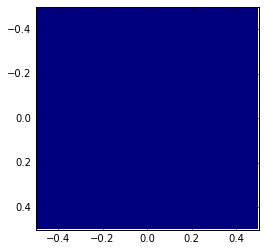

Classes: nonfunc, Prediction 0.727860
Displaying activation map 0


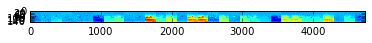

Displaying activation map 1


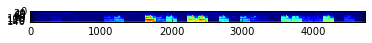

Displaying activation map 2


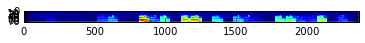

Displaying activation map 3


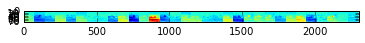

Displaying activation map 4


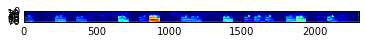

Displaying activation map 5


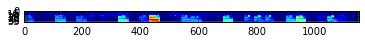

Displaying activation map 6


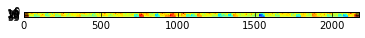

Displaying activation map 7


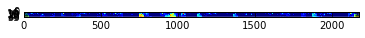

Displaying activation map 8


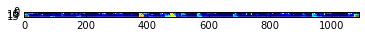

Displaying activation map 9


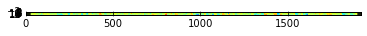

Displaying activation map 10


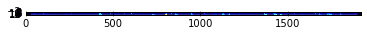

Displaying activation map 11


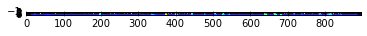

Displaying activation map 12


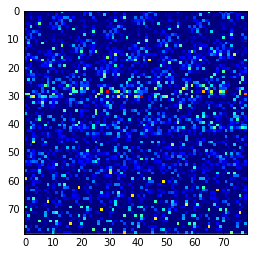

Displaying activation map 13


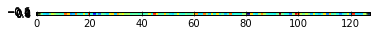

Displaying activation map 14


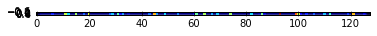

Displaying activation map 15


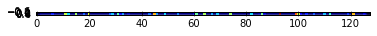

Displaying activation map 16


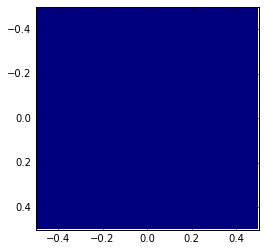

In [16]:
for folder, optimizer in configurations[0:1]:
    optimizer_name = optimizer.__class__.__name__
    filename = 'split_%s_%s_le-4_do0%s_%s_%s' % (
        folder, optimizer_name, int(dropout * 10), batch_size, epochs)
    print 'Building basic %s model for "%s" using "%s"' % (filename, folder, optimizer_name)
    
    run(analytics=True,
        class_mode='binary',
        filename=filename,
        validation_data_dir='data/split/%s/validation' % folder,
        num_images=3,
        save_model_plot=True)

Build a model to distinguish between 3 types of waterpoint

In [ ]:
run(basic=True,
    init_model_fn=lambda: create_model(
        activation='softmax',
        classes=3,
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(lr=init_lr, decay=init_lr / epochs)),
    class_mode='categorical',
    filename='type_adam',
    train_data_dir='data/type/train',
    validation_data_dir='data/type/validation')